<a href="https://colab.research.google.com/github/lupis30puc/BERT_interpretation_with_RF/blob/main/categories_yelp_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Yelp dataset on kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset)

On this notebook I create new general categories for the reviews and divide the sample dataset on a train and validation set.

Reference notebooks: [Sentiment analysis with Yelp and BERT](https://signal.onepointltd.com/post/102gc83/sentiment-analysis-with-yelp-and-bert), [Gil Mendez's repository](https://github.com/onepointconsulting/yelp_bert/blob/master/preprocess_data.ipynb), [Sentiment Analysis on Yelp reviews](https://github.com/Sonull/Sentiment-Analysis-on-Yelp-Reviews/blob/master/RF_and_SVM1.ipynb)



## Setup

In [ ]:
# function to set up the graphs' style
def set_plotting_style():
  tw = 1.5
  rc = {'lines.linewidth': 2,
              'axes.labelsize': 18,
              'axes.titlesize': 21,
              'xtick.major' : 16,
              'ytick.major' : 16,
              'xtick.major.width': tw,
              'xtick.minor.width': tw,
              'ytick.major.width': tw,
              'ytick.minor.width': tw,
              'xtick.labelsize': 'large',
              'ytick.labelsize': 'large',
              'font.family': 'sans',
              'weight':'bold',
              'grid.linestyle': ':',
              'grid.linewidth': 1.5,
              'grid.color': '#ffffff',
              'mathtext.fontset': 'stixsans',
              'mathtext.sf': 'fantasy',
              'legend.frameon': True,
              'legend.fontsize': 12, 
            "xtick.direction": "in","ytick.direction": "in"}

  plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
  plt.rc('mathtext', fontset='stixsans', sf='sans')
  sns.set_style('ticks', rc=rc)
  sns.set_context('notebook', rc=rc)


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split

In [ ]:
# connecting to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# reading the pre-processed sample
whole_sample = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_yelp_reviews_cleaned.pkl')
whole_sample.head()

,text,label,categories,clean_text
0,This actually used to be one of my favorite ho...,0,"Casinos, Nightlife, Restaurants, Hotels & Trav...",actually favorite hotel casinos day things cha...
1,Decent food. Fishermen lobster or even congee ...,0,"Seafood, Restaurants, Food, Chinese, Seafood M...",decent food fishermen lobster congee queen bet...
2,"Pros: Fun atmosphere, great for people watchin...",0,"Nightlife, Bars, American (Traditional), Music...",pros fun atmosphere great people watching mech...
3,"I love bookstores, and I love to spend some ti...",0,"Shopping, Bookstores, Books, Mags, Music & Video",love bookstores love spend time browsing flipp...
4,"I passed Five Guys, In-N-Out, Carl's Jr, and S...",0,"Burgers, Restaurants, Salad, Sandwiches",passed guys carl sonic habit won happen know s...


## Analzing the categories from the sample reviews manually

In [ ]:
whole_sample.shape

(12993, 4)

In [ ]:
len(whole_sample['categories'].unique())

4000

In [ ]:
whole_sample[whole_sample.categories.isna()==True]

,text,label,categories,clean_text
2410,"*Okay, this is strictly based on their ""10,000...",0,None,okay strictly based egg easter egg hunt event ...
4744,Houses The Light Factory and McGlohn Theater. ...,1,None,houses light factory mcglohn theater saturday ...
5985,My friend tried so hard to work with this guy....,0,None,friend tried hard work guy spoiled brat shopping
8442,STAY CLEAR! Canmax sales reps promise a great...,0,None,stay clear canmax sales reps promise great opp...


In [ ]:
whole_sample.fillna('Other Industries', inplace=True)

In [ ]:
whole_sample['categories'].describe()

count                                                 12993
unique                                                 4000
top       Arts & Entertainment, Casinos, Hotels, Hotels ...
freq                                                    125
Name: categories, dtype: object

In [ ]:
whole_sample['categories'].unique()[:10]

array(['Casinos, Nightlife, Restaurants, Hotels & Travel, Tennis, Active Life, Steakhouses, Event Planning & Services, Music Venues, Sushi Bars, Arts & Entertainment, Food, Japanese, Hotels',
       'Seafood, Restaurants, Food, Chinese, Seafood Markets, Specialty Food, Dim Sum, Japanese',
       'Nightlife, Bars, American (Traditional), Music Venues, Dance Clubs, Restaurants, Arts & Entertainment, Beer, Wine & Spirits, Cocktail Bars, Lounges, Food, Event Planning & Services, Sports Bars, Venues & Event Spaces',
       'Shopping, Bookstores, Books, Mags, Music & Video',
       'Burgers, Restaurants, Salad, Sandwiches',
       'Restaurants, Asian Fusion, Japanese, Bars, Sushi Bars, Nightlife',
       'Pet Groomers, Pet Services, Pets',
       'Japanese, Sushi Bars, Restaurants', 'Hotels & Travel, Airports',
       'Nightlife, Dance Clubs'], dtype=object)

In [ ]:
whole_sample['categories'].value_counts().loc[lambda x : x>50].to_frame()

,categories
"Arts & Entertainment, Casinos, Hotels, Hotels & Travel, Event Planning & Services",125
"Mexican, Restaurants",114
"Restaurants, Mexican",90
"Restaurants, Chinese",80
"French, Cafes, Restaurants, Cocktail Bars, Nightlife, Venues & Event Spaces, Event Planning & Services, Bars, Breakfast & Brunch",79
"Chinese, Restaurants",73
"Southern, Mexican, New Mexican Cuisine, Spanish, Tex-Mex, Barbeque, Restaurants, American (Traditional), American (New)",69
"Beauty & Spas, Nail Salons",61
"Restaurants, Pizza",61


In [ ]:
most_repeated = whole_sample['categories'].value_counts().loc[lambda x : x>50].to_frame()
most_repeated.reset_index(inplace=True)
most_repeated.columns = ['categories', 'count']
type(most_repeated)
most_repeated

,categories,count
0,"Arts & Entertainment, Casinos, Hotels, Hotels ...",125
1,"Mexican, Restaurants",114
2,"Restaurants, Mexican",90
3,"Restaurants, Chinese",80
4,"French, Cafes, Restaurants, Cocktail Bars, Nig...",79
5,"Chinese, Restaurants",73
6,"Southern, Mexican, New Mexican Cuisine, Spanis...",69
7,"Beauty & Spas, Nail Salons",61
8,"Restaurants, Pizza",61


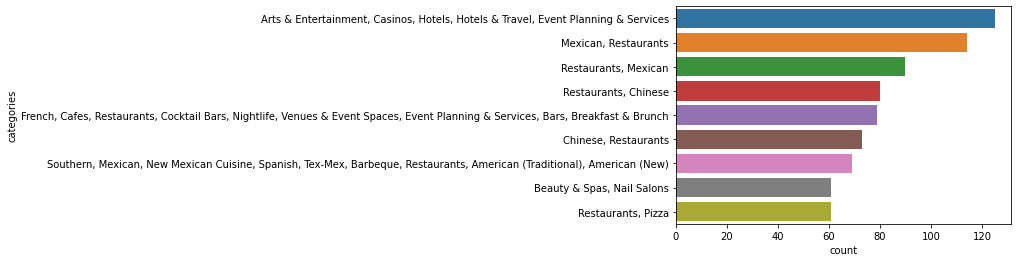

In [ ]:
sns.barplot(data=most_repeated, y='categories', x='count')

In [ ]:
# the threshold would be 5% of the whole sample
12993*0.05
# the new categories groups should have at least this amount of reviews:

649.6500000000001

In [ ]:
hotel_ = whole_sample['categories'][whole_sample['categories'].str.contains('Hotel')== True]
beauty_ = whole_sample['categories'][whole_sample.categories.isin(hotel_)==False][whole_sample['categories'].str.contains('Beauty')== True]
restaurants_ = whole_sample['categories'][whole_sample.categories.isin(hotel_.append(beauty_))==False][whole_sample['categories'].str.contains('Restaurant')==True]

In [ ]:
# this categories have more than 5% of the reviews
len(hotel_), len(beauty_), len(restaurants_)

(727, 695, 8495)

In [ ]:
# looking for the tags on the remaining categories
whole_sample['categories'][whole_sample.categories.isin(hotel_.append([beauty_, restaurants_]))==False].value_counts().loc[lambda x : x>13].to_frame()

,categories
"Food, Coffee & Tea",48
"Coffee & Tea, Food",46
"Arts & Entertainment, Performing Arts",26
"Cinema, Arts & Entertainment",26
"Car Dealers, Auto Repair, Automotive",26
"Ice Cream & Frozen Yogurt, Food",24
"Pet Groomers, Pet Stores, Pets, Pet Services",15
"Automotive, Car Dealers, Auto Repair",14
"Hiking, Active Life, Parks, Rock Climbing, Local Flavor, Mountain Biking",14


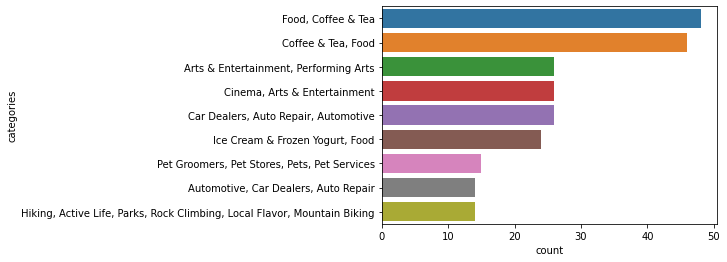

In [ ]:
most_repeated2 = whole_sample['categories'][whole_sample.categories.isin(hotel_.append([beauty_, restaurants_]))==False].value_counts().loc[lambda x : x>13].to_frame()
most_repeated2.reset_index(inplace=True)
most_repeated2.columns = ['categories', 'count']
#most_repeated2
sns.barplot(data=most_repeated2, y='categories', x='count')

In [ ]:
# joining food with restaurants 
# edited march 2021
food_ = whole_sample['categories'][whole_sample.categories.isin(hotel_.append([beauty_, restaurants_]))==False][whole_sample['categories'].str.contains('Food')==True]
arts_ = whole_sample['categories'][whole_sample.categories.isin(hotel_.append([restaurants_, beauty_]))==False][whole_sample['categories'].str.contains('Arts')==True]
cars_ = whole_sample['categories'][whole_sample.categories.isin(hotel_.append([restaurants_, beauty_]))==False][whole_sample['categories'].str.contains('Auto')==True]
pets_ = whole_sample['categories'][whole_sample.categories.isin(hotel_.append([restaurants_, beauty_]))==False][whole_sample['categories'].str.contains('Pet')==True]
active_ = whole_sample['categories'][whole_sample.categories.isin(hotel_.append([restaurants_, beauty_]))==False][whole_sample['categories'].str.contains('Active')==True]
# none of the new groups is above the threshold, but beauty gets near...
len(food_), len(arts_), len(cars_), len(pets_), len(active_)

(681, 339, 419, 124, 280)

In [ ]:
# joining shopping and beauty, and restaurants and food; because of its similar nature
#shopping_beauty = whole_sample['categories'][whole_sample.categories.isin(hotel_)==False][whole_sample['categories'].str.contains('Beauty|Shopping')== True]
#restaurants_food = whole_sample['categories'][whole_sample.categories.isin(hotel_.append(shopping_beauty))==False][whole_sample['categories'].str.contains('Restaurant|Food')==True]
restaurants_food = whole_sample['categories'][whole_sample.categories.isin(hotel_.append(beauty_))==False][whole_sample['categories'].str.contains('Restaurant|Food')==True]

In [ ]:
#edited march
whole_sample['categories'][whole_sample.categories.isin(hotel_.append([beauty_, restaurants_food, arts_, cars_, pets_, active_]))==False].value_counts().loc[lambda x: x > 10].to_frame()

,categories
"Health & Medical, Medical Centers, Doctors, Urgent Care",12
"Electronics, Security Systems, Local Services, Home Services, Local Flavor, Mobile Phone Repair, IT Services & Computer Repair, Mobile Phones, Electronics Repair, Shopping",11
"Local Services, Home & Garden, Hardware Stores, Computers, Electronics, Department Stores, Appliances, Shopping, IT Services & Computer Repair, Fashion, Appliances & Repair",11


In [ ]:
# confirming that no other group reaches the threshold
health_ = whole_sample['categories'][whole_sample.categories.isin(hotel_.append([restaurants_food, beauty_]))==False][whole_sample['categories'].str.contains('Health')==True]
services_ = whole_sample['categories'][whole_sample.categories.isin(hotel_.append([restaurants_food, beauty_]))==False][whole_sample['categories'].str.contains('Service')==True]

len(health_),len(services_)

(289, 945)

In [ ]:
len(hotel_) +len(beauty_) + len(restaurants_food) + len(services_)

11543

In [ ]:
len(whole_sample)

12993

In [ ]:
12993-11543

1450

In [ ]:
len(restaurants_food)

9176

In [ ]:
# making other category that include all reviews
other = whole_sample['categories'][whole_sample.categories.isin(hotel_.append([beauty_, restaurants_food, services_]))==False]
# finally we obtain 4 categories 
len(hotel_), len(beauty_), len(restaurants_food), len(services_), len(other)

(727, 695, 9176, 945, 1450)

In [ ]:
other.value_counts().to_frame()

,categories
"Car Dealers, Auto Repair, Automotive",26
"Cinema, Arts & Entertainment",26
"Arts & Entertainment, Performing Arts",26
"Hiking, Active Life, Parks, Rock Climbing, Local Flavor, Mountain Biking",14
"Automotive, Car Dealers, Auto Repair",14
...,...
"Sports Bars, Pubs, Nightlife, Beer Bar, Cocktail Bars, Bars",1
"Nightlife, Pool Halls",1
"Nightlife, Arts & Entertainment, Bars, Dive Bars, Music Venues",1
"Ticket Sales, Arts & Entertainment",1


In [ ]:
# the new categories indeed cover all reviews
len(hotel_)+ len(beauty_)+len(restaurants_food)+ len(services_)+ len(other)

12993

In [ ]:
whole_sample['category'] = ""
whole_sample.loc[hotel_.index,['category']] = "Hotel Industry"
whole_sample.loc[beauty_.index,['category']] = "Beauty Industry"
whole_sample.loc[restaurants_food.index,['category']] = "Restaurant Industry"
whole_sample.loc[services_.index,['category']] = "Service Industry"
whole_sample.loc[other.index,['category']] = "Other Industries"
whole_sample.head()

,text,label,categories,clean_text,category
0,This actually used to be one of my favorite ho...,0,"Casinos, Nightlife, Restaurants, Hotels & Trav...",actually favorite hotel casinos day things cha...,Hotel Industry
1,Decent food. Fishermen lobster or even congee ...,0,"Seafood, Restaurants, Food, Chinese, Seafood M...",decent food fishermen lobster congee queen bet...,Restaurant Industry
2,"Pros: Fun atmosphere, great for people watchin...",0,"Nightlife, Bars, American (Traditional), Music...",pros fun atmosphere great people watching mech...,Restaurant Industry
3,"I love bookstores, and I love to spend some ti...",0,"Shopping, Bookstores, Books, Mags, Music & Video",love bookstores love spend time browsing flipp...,Other Industries
4,"I passed Five Guys, In-N-Out, Carl's Jr, and S...",0,"Burgers, Restaurants, Salad, Sandwiches",passed guys carl sonic habit won happen know s...,Restaurant Industry


In [ ]:
whole_sample[whole_sample.category.isna()==True]

,text,label,categories,clean_text,category


In [ ]:
whole_sample['category'].value_counts()

Restaurant Industry    9176
Other Industries       1450
Service Industry        945
Hotel Industry          727
Beauty Industry         695
Name: category, dtype: int64

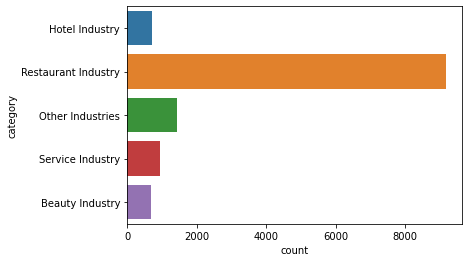

In [ ]:
sns.countplot(data=whole_sample, y='category')

In [ ]:
whole_sample['category'].value_counts().apply(lambda c: round(c / len(whole_sample) *100), print('Percentages:'))

Percentages:


Restaurant Industry    71
Other Industries       11
Service Industry        7
Hotel Industry          6
Beauty Industry         5
Name: category, dtype: object

(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 <a list of 6 Text major ticklabel objects>)

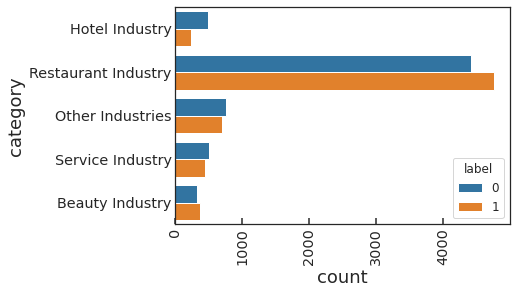

In [ ]:
set_plotting_style()
sns.countplot(y='category', hue='label', data=whole_sample)
plt.xticks(rotation=90)
# 0 is 'negative', 1 is 'positive'

## Wordclouds and graphs

In [ ]:
from wordcloud import WordCloud
# creating a function to make word clouds for any category group
def group_cloud(category_group):
  reviews = whole_sample['clean_text'][whole_sample.index.isin(other[other.isin(category_group)].index)].str.cat(sep=' ')
  reviews = ' '.join([word for word in reviews.split()])
  cloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(reviews)
  plt.figure()
  plt.imshow(cloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

Shopping group


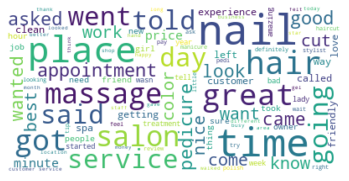

In [ ]:
print('Shopping group')
group_cloud(shopping_)

Arts group


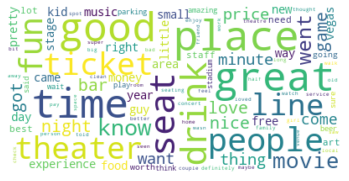

In [ ]:
print('Arts group')
group_cloud(arts_)

Cars group


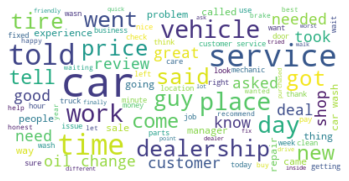

In [ ]:
print('Cars group')
group_cloud(cars_)

Health group


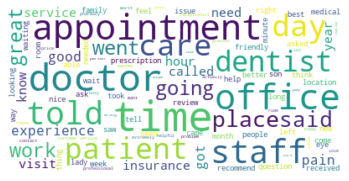

In [ ]:
print('Health group')
group_cloud(health_)

Active group


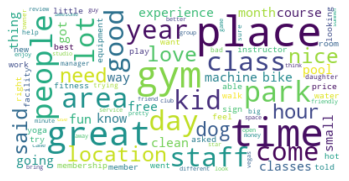

In [ ]:
print('Active group')
group_cloud(active_)

Pets group


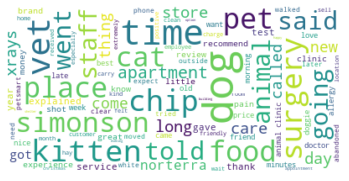

In [ ]:
print('Pets group')
group_cloud(pets_)

As we can observe this groups have indeed several distinct words, which would makes them potentially good categories. However, they don't reach the threshold of 5%. As future steps, one could analyze reviews for these specific categories. 

Cluster: Hotel Industry


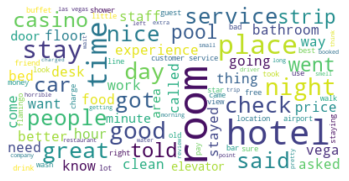

Cluster: Restaurant Industry


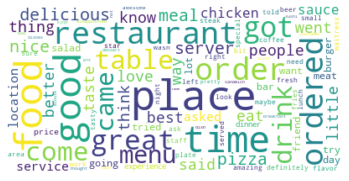

Cluster: Other Industries


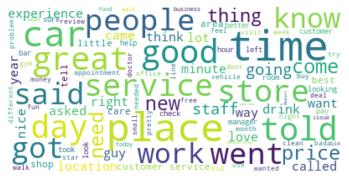

Cluster: Service Industry


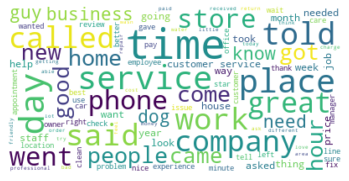

Cluster: Beauty Industry


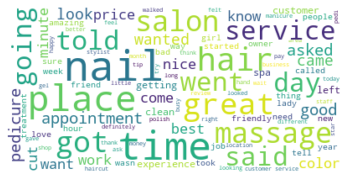

In [ ]:
manual_cat = list(whole_sample['category'])
test_rev = list(whole_sample['clean_text'])
n_cat = list(whole_sample.category.unique())

result={'category':manual_cat,'review':test_rev}
result=pd.DataFrame(result)
for k in n_cat:
   s=result[result.category==k]
   text=s['review'].str.cat(sep=' ')
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   #print('Titles')
   #titles=cat_clust[cat_clust.cluster==k]['title']         
   #print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

#to save clouds
#cloud.to_file("wordcloud.png")

In [ ]:
whole_sample.groupby('label')['category'].value_counts()

label  category           
0      Restaurant Industry    4420
       Other Industries        755
       Service Industry        506
       Hotel Industry          493
       Beauty Industry         323
1      Restaurant Industry    4756
       Other Industries        695
       Service Industry        439
       Beauty Industry         372
       Hotel Industry          234
Name: category, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

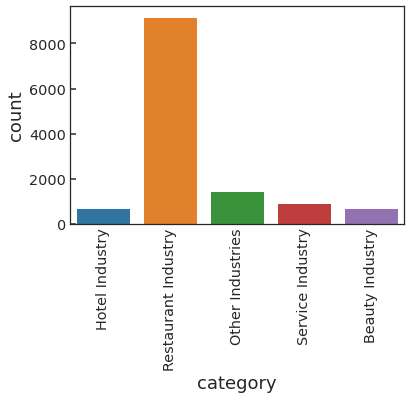

In [ ]:
set_plotting_style()
plot = sns.countplot(whole_sample['category'])
plt.xticks(rotation=90)

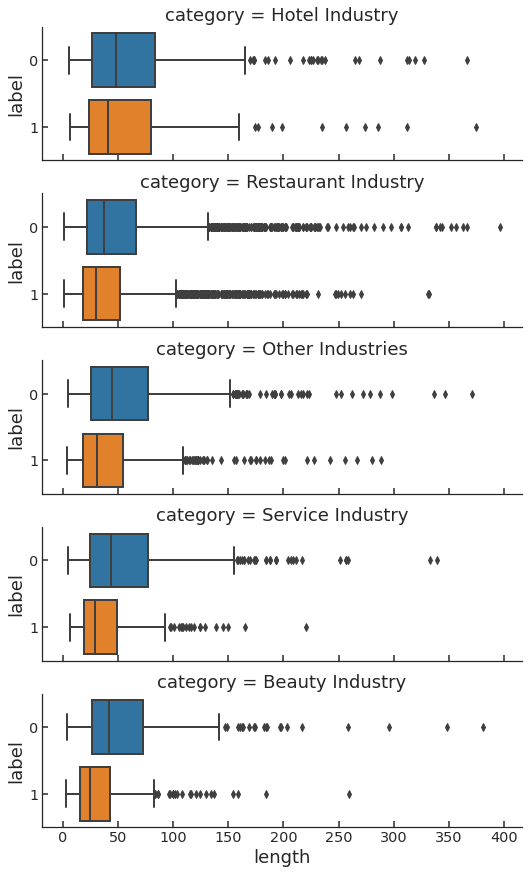

In [ ]:
# observing the length distribution per label and category
g = sns.catplot(x="length", y="label", row="category",
                 data=whole_sample,orient="h", height=2.4, aspect=3, palette="tab10", kind="box")

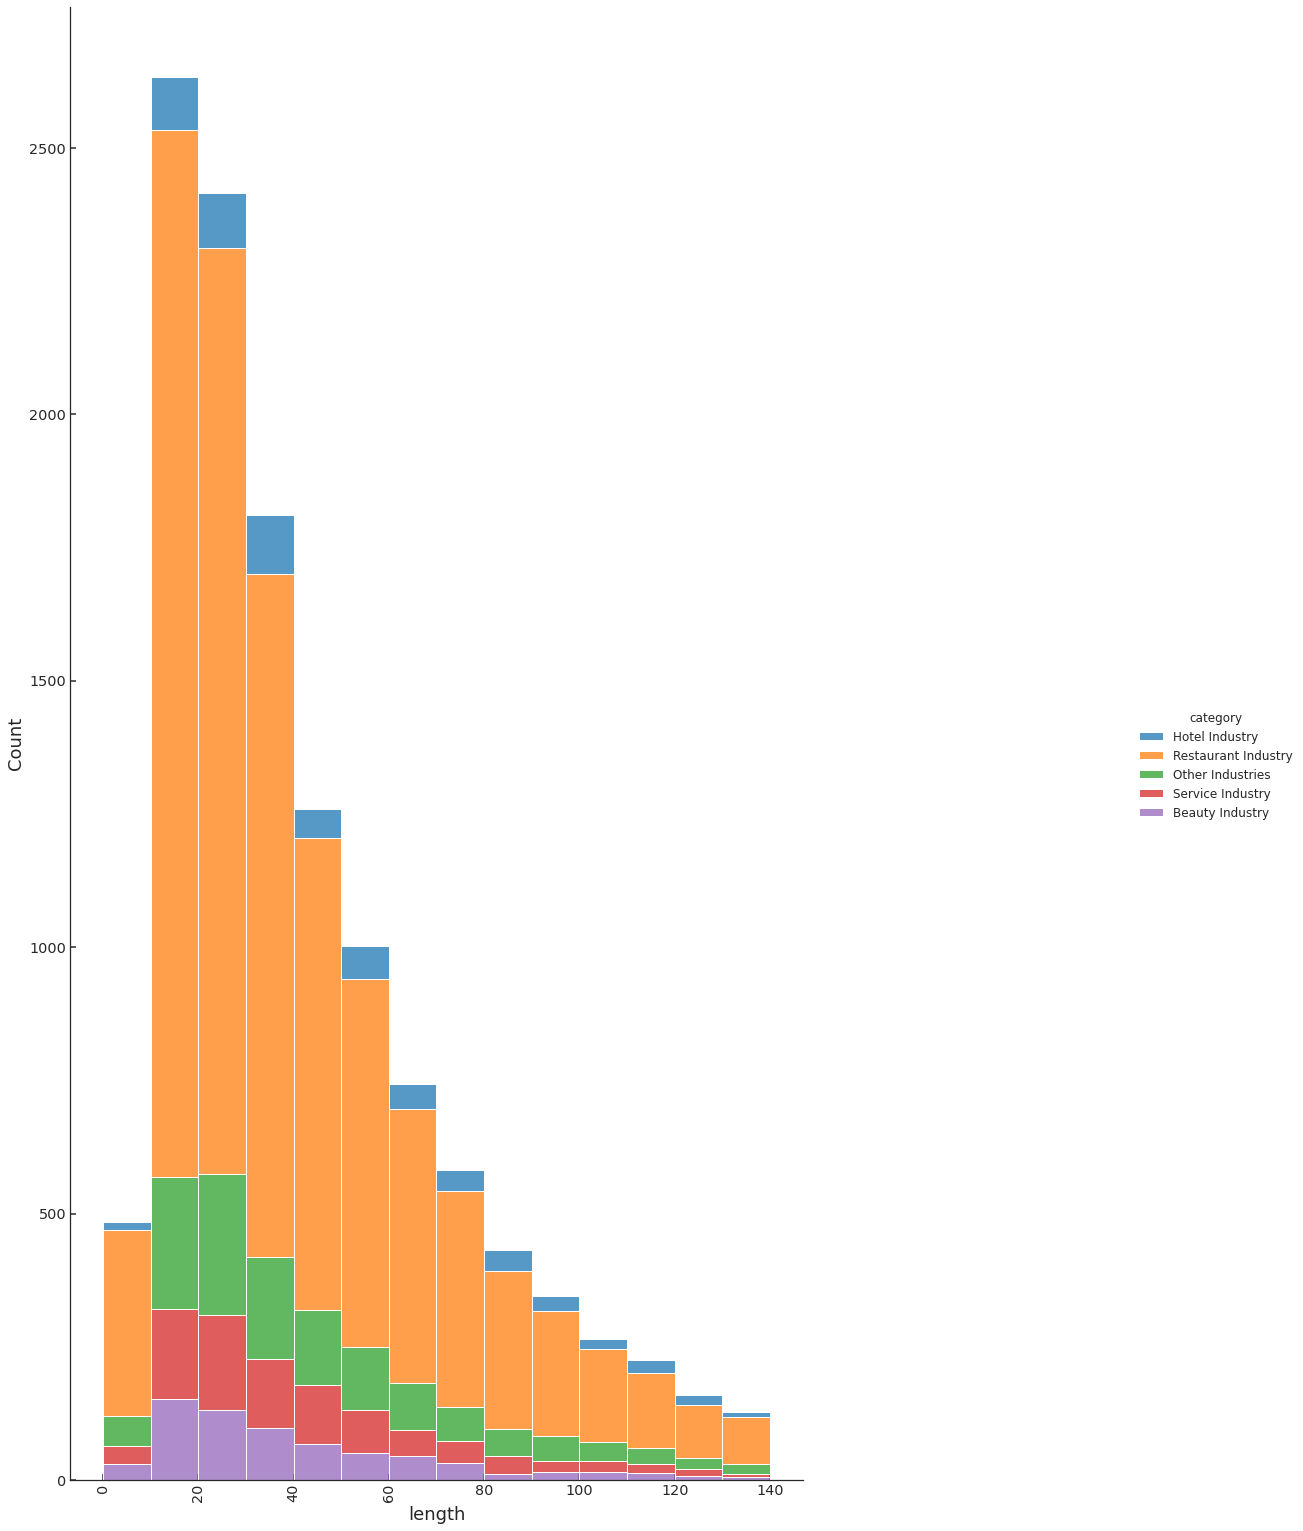

In [ ]:
# checking the sample reviews' length distribution per category
plot2 = sns.displot(data=whole_sample, x='length', hue='category', multiple='stack', bins=np.arange(0,150,10))
plt.xticks(rotation=90)
plot2.fig.set_figwidth(20)
plot2.fig.set_figheight(25)

## Splitting into train, test and validation sets

In [ ]:
# saving the sample with the new category column
whole_sample.to_pickle('/content/drive/MyDrive/Yelp/sample_categories.pkl')
whole_sample.drop(columns=['categories'], inplace=True)

In [ ]:
RANDOM_SEED = 42
sample_train, sample_test = train_test_split(whole_sample, test_size=0.20, random_state=RANDOM_SEED, 
                                     stratify=whole_sample.label.values)
sample_train.shape, sample_test.shape

((10394, 5), (2599, 5))

In [ ]:
sample_train.to_pickle('/content/drive/MyDrive/Yelp/sample_train_10394.pkl')
sample_test.to_pickle('/content/drive/MyDrive/Yelp/sample_test_2599.pkl')

In [ ]:
sample_train.head(2)

,text,label,clean_text,category,length
11349,"Second best pool in Las Vegas! Pay the $20, c...",1,second best pool las vegas pay commit day drin...,Hotel Industry,33
12582,We went there on a Tuesday night in Jan. 2010....,0,went tuesday night jan weather nice course dec...,Restaurant Industry,56


In [ ]:
sample_train.groupby('label')['category'].value_counts().loc[lambda x: x > 10]

label  category           
0      Restaurant Industry    3537
       Other Industries        615
       Service Industry        397
       Hotel Industry          385
       Beauty Industry         263
1      Restaurant Industry    3797
       Other Industries        554
       Service Industry        355
       Beauty Industry         303
       Hotel Industry          188
Name: category, dtype: int64

In [ ]:
whole_sample.loc[whole_sample['category'].str.contains('Restaurant*', flags=re.IGNORECASE)== True]['label'].value_counts()

1    4756
0    4420
Name: label, dtype: int64

In [ ]:
sample_test.head(2)

,text,label,clean_text,category,length
1063,Positives: \n- good location \n- staff reasona...,0,positives good location staff reasonably frien...,Beauty Industry,66
1757,"Very clean hotel.jacuzzi is very huge,shower a...",0,clean hotel jacuzzi huge shower bathroom huge ...,Hotel Industry,50


In [ ]:
sample_test.groupby('label')['category'].value_counts()

label  category           
0      Restaurant Industry    883
       Other Industries       140
       Service Industry       109
       Hotel Industry         108
       Beauty Industry         60
1      Restaurant Industry    959
       Other Industries       141
       Service Industry        84
       Beauty Industry         69
       Hotel Industry          46
Name: category, dtype: int64

## Length EDA per label and set

**Confirming that thse subsets have the same distribution**

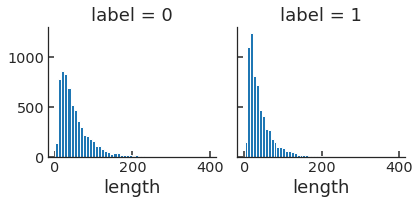

In [ ]:
# the whole sample
graph = sns.FacetGrid(data=whole_sample,col='label')
graph.map(plt.hist,'length',bins=50)
# 0 negative, 1 positive

In [ ]:
# the train set
sample_train['length'].describe()

count    10394.000000
mean        47.675486
std         41.615668
min          1.000000
25%         20.000000
50%         35.000000
75%         61.000000
max        381.000000
Name: length, dtype: float64

In [ ]:
#checking the 90% quantile from all the sample
train_90 = np.quantile(sample_train['length'], 0.90)
#checking the 95% quantile from all the sample
train_95 = np.quantile(sample_train['length'], 0.95)
print(train_90, train_95)

99.0 127.0


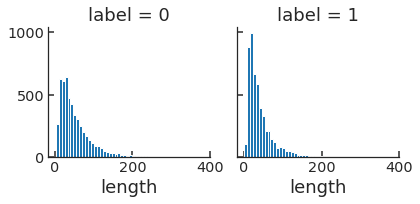

In [ ]:
# train set
graph = sns.FacetGrid(data=sample_train,col='label')
graph.map(plt.hist,'length',bins=50)
# 0 negative, 1 positive

In [ ]:
#test set
sample_test['length'].describe()

count    2599.000000
mean       47.890342
std        43.819332
min         1.000000
25%        20.000000
50%        34.000000
75%        61.000000
max       396.000000
Name: length, dtype: float64

In [ ]:
#checking the 90% quantile from all the sample
test_90 = np.quantile(sample_test['length'], 0.90)
#checking the 95% quantile from all the sample
test_95 = np.quantile(sample_test['length'], 0.95)
print(train_90, train_95)

99.0 127.0


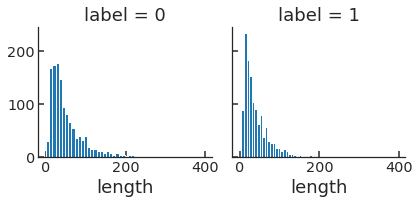

In [ ]:
# test set 
graph = sns.FacetGrid(data=sample_test,col='label')
graph.map(plt.hist,'length',bins=50)